In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Oct 27 12:26:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install -q pydicom 

     |████████████████████████████████| 2.0 MB 5.2 MB/s 


In [ ]:
# Imports
import os
import cv2
import pydicom

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pylab as plt
import tensorflow as tf
%matplotlib inline

#from google.colab import drive

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

import skimage
from skimage.transform import resize
from skimage import feature, filters
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random
import pickle

In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
print(pydicom.__version__)

2.2.2


In [ ]:
output_path = '/content/gdrive/MyDrive/Capstone/Data/'
patient_df_path = output_path + 'patient_df.pb'
train_path = '/content/gdrive/MyDrive/Capstone/Data/stage_2_train_images/'
input_path="/content/gdrive/MyDrive/Capstone/Data/"

# output weights filepaths
#cust_unet_path = './cust_unet_seg.h5'
#mobilenet_unet_path = './umobilnet_seg.h5'
#basic_cnn_path = './basic_cnn_seg.h5'
basic_unet_i64_b64_e6_path = '/content/gdrive/MyDrive/Capstone/Data/basic_unet_i64_b64_e6_seg.h5'

# Pickle output files
#basic_cnn_history = output_path + 'BasicCNN_history.pickle'
#basic_unet_history = output_path + 'BasicUnet_history.pickle'
#unet_mobnet_history = output_path + 'unet_mobnet_history.pickle'
basic_unet_i64_b64_e6_history = output_path + 'basic_unet_i64_b64_e6_history.pickle'

#basic_cnn_creport = output_path +"BasicCNN_creport.pickle"
#basic_unet_creport = output_path + "BasicUnet_creport.pickle"
#unet_mobnet_creport = output_path +'unet_mobnet_creport.pickle"
basic_unet_i64_b64_e6_creport = output_path + 'basic_unet_i64_b64_e6_creport.pickle'

# Model filepaths
#basic_cnn_model = output_path + 'BasicCNN_model.h5'
#basic_unet_model = output_path + "BasicUnet_model.h5"
#unet_mobnet_model = output_path + "unet_mobnet_model.h5"
basic_unet_i64_b64_e6_model_path = output_path + 'basic_unet_i64_b64_e6_model.h5'

In [ ]:
IMAGE_SHAPE = [1024,1024]
IMG_PATH = train_path
INPUT_SIZE_64 = [64,64,3]
BATCH_SIZE_8 = 8
BATCH_SIZE_32 = 32
BATCH_SIZE_64 = 64
EPOCH_SIZE = 6

In [ ]:
def get_img(img_path, patientId):
    '''Function to get an pixel array image from dcm file'''

    dcm_filename = img_path + patientId + '.dcm'
    dcm_img = pydicom.read_file(dcm_filename)
    
    img = dcm_img.pixel_array
    return dcm_filename,img

def get_mask(bboxes, input_size):
    '''Function to get mask given the bounding box co-ordinates and the image_size'''
    
    # add 1's at the location of pneumonia
    mask = np.zeros(IMAGE_SHAPE) # Black background
    for bbox in bboxes:
        if ( not np.isnan(bbox).any()):
            xmin, ymin, width, height = [int(i) for i in bbox] # Get box co-ordinates
            mask[ymin:ymin+height, xmin:xmin+width] = 1 # Color Highlight the pneumonia area
        
    mask = resize(mask,input_size, mode='reflect') # resize output mask to  input size
    return (mask)

def draw_box(image, box):
    '''Function to draw a rectangle on an image'''

    # Convert coordinates to integers
    box = map(int, box)
    
    # Extract coordinates for rectangle
    x, y, width, height = box
    x1 = x + width
    y1 = y + height
   
    color = (255, 0, 0) 
    thickness = 8
    
    # Draw a rectangle with line borders of thickness of 8 px 
    image = cv2.rectangle(image, (x,y), (x1,y1), color, thickness) 

    return image

def get_boxes(patient_df, patientId):
    ''' Return bboxes for the given patientId'''
    
    return patient_df[patient_df['patientId'] == patientId]['bboxes'].values[0]


def draw_bounded_image(img_path, patient_df, patientId):
    '''Bound the image with boxes covering the affected pneumonia areas'''

    # Get pixel image array
    file,image = get_img(img_path, patientId)

    # Get box co-ordinates for this patient
    boxes = get_boxes(patient_df, patientId)

    # Add the boxes to image
    for box in boxes:
        if ( np.isnan(np.sum(boxes)).any() ) : # Check if image is of a person without penumonia i.e box = NaN)
            break;
        else:
            image = draw_box(image=image, box=box) # Overlay the box on the image

    return file,image

In [ ]:
def printTwoImgs(img1, img2, title1, title2):
    
    fig, ax = plt.subplots(1, 2, figsize=(10,10))

    ax[0].imshow(img1, cmap="gray")
    ax[1].imshow(img2, cmap="gray")
    
    ax[0].set_title(title1)
    ax[1].set_title(title2)
    
    ax[0].axis('off')
    ax[1].axis('off')

In [ ]:
# Define the preprocess input function to be called from CustomDataGen
def preprocess_input(X):
  ''' Function to preprocess image. This can vary if we use imported model architectures'''
  return X/255

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    '''Define Custom Data Generator'''
    # Keras ImageDataGenerator cannot be used because of not able to handle DICOM images easily
    # as well as to create masks in batches, to save memory

    # Called on initialization
    def __init__(self, df,
                 batch_size,
                 input_size=INPUT_SIZE_64,
                 shuffle=True,
                 augment = 'no',
                ):
        
        self.df = df.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.augment = augment
        self.n = len(self.df)

    # Private method called by __getdata. Creates masks for an image
    def __getmask(self, bboxes, input_size):

        # add 1's at the location of pneumonia
        mask = np.zeros(IMAGE_SHAPE) # Black background
        for bbox in bboxes:
            if ( not np.isnan(bbox).any()):
                xmin, ymin, width, height = [int(i) for i in bbox] # Get box co-ordinates
                mask[ymin:ymin+height, xmin:xmin+width] = 1 # Color Highlight the pneumonia area
        
        mask = resize(mask,self.input_size, mode='reflect') # resize output mask to  input size
        return (mask)

    # Private method called by __getdata. Gets pixel image array and preprocesses it (UNET backbone)
    def __getimage(self, path, image_size):
        image_arr = pydicom.read_file(path).pixel_array
        image_arr = np.stack((image_arr,)*3, axis=-1) # Expand grayscale image to contain 3 channels
        image_arr = resize(image_arr,self.input_size, mode='reflect')
        return (image_arr)
    
    # Private method called by __getitem__. Gets X and y for a batch
    def __getdata(self, batches):
        # Generates data containing batch_size samples of features(image pixels array) and targets(mask and label)

        batch_paths = [IMG_PATH + patientId + '.dcm' for patientId in batches['patientId']]
        batch_bboxes = batches['bboxes'].values

        X_batch = np.asarray([self.__getimage(path, self.input_size) for path in batch_paths])

        y_batch = np.asarray([self.__getmask( bbox, self.input_size) 
                               for bbox in batch_bboxes])
        return X_batch, y_batch

    # Mandatory Sequence class method, called to yield the next batch of data at index 
    def __getitem__(self, index):
        batch_start = index * self.batch_size
        batch_end = (index + 1) * self.batch_size
        batches = self.df[batch_start:batch_end]
        X_batch, y_batch = self.__getdata(batches) 
        X_batch = preprocess_input(X_batch)
        return X_batch, y_batch
    
    # Mandatory Sequence class method. Get number of steps in an epoch that runs all batches to update the model
    def __len__(self):
        return self.n // self.batch_size

    # Optional Sequence class method, called at the end of every epoch during model run. 
    def on_epoch_end(self):
        # Shuffle data at end of every epoch                       
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [ ]:
def conv2d_block(input_tensor, n_filters=16):
    """Function to add 2 convolutional layers with the parameters passed to it"""

    # first convolution
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
  
    # second convolution
    x = tf.keras.layers.Conv2D(n_filters, (3,3), kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [ ]:
def create_cnnmodel(input_size=INPUT_SIZE_64):
    
    #Define input layer
    input_tensor = tf.keras.layers.Input(input_size, name='input_layer')
    
    #First double convolution block
    n_filters = 16
    c1 = conv2d_block(input_tensor, n_filters*1)
    c2 = conv2d_block(c1, n_filters*2)
    c4 = conv2d_block(c2, n_filters*4)

    #Build the Output layer
    outputs = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(c4) 

    #Build the model using different layers
    model = tf.keras.Model(inputs=[input_tensor], outputs=[outputs])
    return model

In [ ]:
def down_sample(tensor, dropout):
    d = tf.keras.layers.MaxPooling2D((2, 2))(tensor) 
    return tf.keras.layers.Dropout(dropout)(d) 
    
def up_sample(tensor, n_filters):
    return tf.keras.layers.Conv2DTranspose(n_filters, (3, 3), 
                                         strides = (2, 2), 
                                         padding = 'same')(tensor)
def concat(tensor1, tensor2, dropout):
    c = tf.keras.layers.concatenate([tensor1, tensor2])
    return tf.keras.layers.Dropout(dropout)(c) 
    
def create_custom_unet(input_size=INPUT_SIZE_64, n_filters=16, dropout=0.4):
    ''' Function to build a custom UNET model from scratch using CNN'''
    
    #Define input layer
    input_tensor = tf.keras.layers.Input(input_size, name='input_layer')

    #ENCODER - DOWNSAMPLE the image

    #First Block of Encoder
    c1 = conv2d_block(input_tensor, n_filters*1) # 64*64*16
    e1 = down_sample(c1, dropout)

    #Second Block of Encoder
    c2 = conv2d_block(e1, n_filters*2) # 32 *32 * 32
    e2 = down_sample(c2, dropout)

    #Central Block of Encoder
    c3 = conv2d_block(e2, n_filters*4) # 16 * 16 * 64

    #We now have output of Encoder

    #DECODER - UPSAMPLE the feature to generate mask

    # Central Block of Decoder
    d3 = conv2d_block(c3, n_filters*4) # 16 * 16 * 64
    
    # First Block of Decoder
    d2 = up_sample(d3, n_filters*4) 
    d2 = concat(d2,c2, dropout) #First Block of Decoder - connected to Second block on Encoder side
    c4 = conv2d_block(d2, n_filters * 2)# 32 * 32 * 32

    # Second Block of Decoder 
    d1 = up_sample(c4, n_filters*2) 
    d1 = concat(d1,c1,dropout) #Second Block of Decoder - connected to First block on Encoder side
    c5 = conv2d_block(d1, n_filters*1)# 64 * 64 * 16
    
    #Build the Output layer
    outputs = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(c5) 

    #Build the model using different layers
    model = tf.keras.Model(inputs=[input_tensor], outputs=[outputs])
    return model

In [ ]:
def create_backbone_unet(backbone, input_size=INPUT_SIZE_64, dropout=0.4):
  '''Function to create UNET model from mobilenet backbone'''
    
  #Freeze Encoder layers
  for layer in backbone.layers:
    layer.trainable = False
  
  model =  backbone
    
  # Build Decoder
  block1 = model.get_layer("conv_pw_1_relu").output 
  block2 = model.get_layer("conv_pw_3_relu").output
  block3 = model.get_layer("conv_pw_5_relu").output
  block6 = model.get_layer("conv_pw_11_relu").output
  block7 = model.get_layer("conv_pw_13_relu").output

  n_filters = 32
  x = Concatenate()([UpSampling2D()(block7), block6])
  x = conv2d_block(x,n_filters * 8)

  x = Concatenate()([UpSampling2D()(x), block3])
  x = conv2d_block(x,n_filters * 4)

  x = Concatenate()([UpSampling2D()(x), block2])
  x = conv2d_block(x,n_filters * 2)

  x = Concatenate()([UpSampling2D()(x), block1])
  x = conv2d_block(x,n_filters)

  x =  UpSampling2D()(x)
  x = conv2d_block(x,n_filters)

  # Output layer
  x = Conv2D(1, kernel_size=1, kernel_initializer='he_normal', padding='same')(x)
  x = tf.keras.layers.Activation('sigmoid')(x)

  return Model(inputs=model.input, outputs=x)

In [ ]:
def create_unet_model(backbone='mobilenet', input_size=INPUT_SIZE_64, dropout=0.4):
    ''' Creates UNET model from different backbone, including no backbone(custom UNET from scratch)'''

    model = MobileNet(input_shape=input_size, include_top=False, alpha=1.0, weights = 'imagenet', dropout=0.4)
    model = create_backbone_unet(model)

    if (backbone == 'None'):
      model = create_custom_unet()

    return model

In [ ]:
# Custom metric and loss functions for validation

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())
  
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

In [ ]:
def PlotMetrics(history):
    plt.figure(figsize=(8, 5))
    plt.grid(True)
    plt.plot(history.history['dice_coefficient'],     label='Train Dice-Coef',      color = "green" );
    plt.plot(history.history['val_dice_coefficient'], label='Val Dice-Coef',  color = "yellow");
    plt.plot(history.history['loss'],         label='Train Loss',          color = "red"   );
    plt.plot(history.history['val_loss'],     label='Val Loss',      color = "orange");
    plt.title("Validation and Training - Loss and Dice Coefficient vs Epoch")
    plt.xlabel("Epoch")
    plt.legend();

In [ ]:
def predict_imagemask(model, patientId, patient_df, train_path, threshold=0.5, input_size=INPUT_SIZE_64):
    '''Function to predict a mask for an image'''

    # Get image pixel array
    _,image = get_img(train_path, patientId)
    image = resize(image,input_size, mode='reflect')

    # Get bboxes and expected mask
    bboxes = patient_df[patient_df['patientId'] == patientId]['bboxes'].values[0]
    mask = get_mask(bboxes, input_size)

    # Prepare the image for feeding into model for 
    image_rescaled = preprocess_input(np.expand_dims(image,0))

    # Predict mask for image
    pred_mask = model.predict(image_rescaled)

    # remove the batch dimension
    pred_mask = pred_mask[0]

    # Mask contains probabilities from sigmoid function. Convert to 0 or 1 values for the pixels, by using a threshold
    pred_mask = (pred_mask > threshold) * 1.0

    return (image,mask,pred_mask)

In [ ]:
def get_predictions(model,val_df,train_path, input_size):
    y_pred = []
    for patientId in val_df['patientId']:
        image,mask,pred_mask = predict_imagemask(model,patientId, val_df, train_path, input_size=input_size)
        y_pred.append((1 in pred_mask) * 1)
    y_true = val_df['Target']
    return y_true, y_pred

In [ ]:
def print_confusion_matrix(y_true, y_pred):
    '''Function to print confusion_matrix'''

    # Get confusion matrix array
    array = confusion_matrix(y_true, y_pred)    
    df_cm = pd.DataFrame(array, range(2), range(2))

    print("Total samples = ", len(val_df))

    # Plot heatmap and get sns heatmap values
    sns.set(font_scale=1.4); # for label size
    result = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False); 

    # Add labels to heatmap
    labels = ['TN=','FP=','FN=','TP=']
    i=0
    for t in result.texts:
        t.set_text(labels[i] + t.get_text())
        i += 1
    
    plt.xlabel("Predicted Values")
    plt.ylabel('True Values')
    plt.show()
    return

In [ ]:
def print_image_mask(image, mask, pred_mask):
    
    # Plot three images side by side
    fig, ax = plt.subplots(1, 3, figsize=(10,10))
    ax[0].imshow(image, cmap=plt.cm.gist_gray) # Show the image
    ax[0].axis('off') # Remove axis
    ax[0].set_title("IMAGE")

    ax[1].imshow(mask*image, cmap=plt.cm.gist_gray)
    ax[1].set_title("Expected Mask")
    ax[1].axis('off')
        
    # Visualize mask superimposed on image 
    masked = mask * image
    ax[2].imshow(masked)
    ax[2].imshow(pred_mask * image)
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')
    plt.show()

In [ ]:

labels_file = input_path + "stage_2_train_labels.csv"
class_file = input_path + "stage_2_detailed_class_info.csv"

labels_df = pd.read_csv(labels_file)
classes_df = pd.read_csv(class_file)

In [ ]:
def get_single_df(patient_df_df,classes_df,df_path, images_path):
    ''' Function to add relevant dicom image metadata columns into dataframe'''

    # If the session has a prestored dataframe pickle use it.
    if (os.path.isfile(df_path)):
        print("Reading prestored dataframe object")
        patient_df = pd.read_pickle(df_path)
        return patient_df
        
    bboxes = [patient_df_df[patient_df_df['patientId'] == patientId].loc[:,'x':'height'].values 
                  for patientId in patient_df_df['patientId']] # Get list of bboxes for each patientId
    
    patient_df = patient_df_df.copy()
    patient_df.insert(1, 'bboxes', bboxes ) # Add new bboxes column
    patient_df.insert(2, 'class', classes_df['class']) #  Add class column

    # Remove x,y, width, height columns and drop the duplicate rows of patientIds 
    patient_df = patient_df.drop(columns=['x','y','width','height']).drop_duplicates(subset=['patientId'], ignore_index=True)
    
    # Initialize columns for DICOM metadata
    patient_df['gender'] = np.nan
    patient_df['age'] = np.nan
    patient_df['viewpos'] = np.nan
    patient_df['dimx'] = np.nan
    patient_df['dimy'] = np.nan

    for patientId in patient_df['patientId']:    
        # Get dcm filename
        dcm_file = images_path + patientId + '.dcm'
        ds = pydicom.dcmread(dcm_file)
    
        # Get the row indices of patientId in dataframe
        indices = patient_df.index[patient_df['patientId'] == patientId].tolist()
    
        # Add the sex, age, viewpos, image dimensions data to the  dataframe
        patient_df.at[indices,'gender'] = ds.PatientSex
        patient_df.at[indices,'age'] = ds.PatientAge
        patient_df.at[indices , 'viewpos'] = ds[0x0018, 0x5101].value
        patient_df.at[indices , 'dimx']    = ds[0x0028, 0x0010].value
        patient_df.at[indices , 'dimy']    = ds[0x0028, 0x0011].value

    # Store the updated patient_df dataframe as an object for faster retrieval in subsequent sessions
    patient_df.to_pickle(df_path) # (not using to_csv because it stores bboxes lists as strings).
    
    return patient_df

In [ ]:
# Get a single dataframe by merging the labels_df and classes_df dataframes and adding relevant DICOM metadata columnspath = patient_df_path
df_path = patient_df_path # dataframe pickle object file to store or retrieve to/from disk
images_path = train_path # path where DICOM images are stored
patient_df = get_single_df(labels_df,classes_df,patient_df_path, images_path)
patient_df.head()

Reading prestored dataframe object


,patientId,bboxes,class,Target,gender,age,viewpos,dimx,dimy
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,"[[nan, nan, nan, nan]]",No Lung Opacity / Not Normal,0,F,51,PA,1024.0,1024.0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,"[[nan, nan, nan, nan]]",No Lung Opacity / Not Normal,0,F,48,PA,1024.0,1024.0
2,00322d4d-1c29-4943-afc9-b6754be640eb,"[[nan, nan, nan, nan]]",No Lung Opacity / Not Normal,0,M,19,AP,1024.0,1024.0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,"[[nan, nan, nan, nan]]",Normal,0,M,28,PA,1024.0,1024.0
4,00436515-870c-4b36-a041-de91049b9ab4,"[[264.0, 152.0, 213.0, 379.0], [562.0, 152.0, ...",Lung Opacity,1,F,32,AP,1024.0,1024.0


In [ ]:
patient_df.shape

(26684, 9)

In [ ]:
print('X dimension of images:' , patient_df['dimx'].value_counts())
print('Y dimension of images:', patient_df['dimy'].value_counts())

X dimension of images: 1024.0    26684
Name: dimx, dtype: int64
Y dimension of images: 1024.0    26684
Name: dimy, dtype: int64


In [ ]:
# To split the dataframe form an array of all the indices
indices = range( len(patient_df))
target = patient_df['Target'] # for stratification split

# First split to get 0.2 of the dataset to use as total samples to input for model
sample_indices, _, sample_target,_ = train_test_split(indices,target, test_size=0.8, random_state=42, stratify=target)

# Split those indices further into train and val indices
train_indices, val_indices, _,_ = train_test_split(sample_indices, sample_target, test_size=0.2, random_state=42, stratify=sample_target)

In [ ]:
# Get the train and validation dataframes from the split indices
patient_data = patient_df[['patientId','bboxes','Target']]
train_df = patient_data.loc[train_indices]
val_df = patient_data.loc[val_indices]

In [ ]:
print("Total Samples: ",len(patient_df) )
total_sample_size = len(train_df) + len(val_df) 
print("Total samples selected for model training:", total_sample_size)
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Ratio of train to validation samples: %0.1f : %0.1f" %(len(train_df)/total_sample_size, len(val_df)/len(sample_indices) ))
print("Positive samples in original dataset: %0.0f%%" %((len(patient_df[patient_df['Target'] == 1])/ len(patient_df))*100))
print("Positive samples in train dataset: %0.0f%%" %((len(train_df[train_df['Target'] == 1]) /len(train_df)) * 100))
print("Positive samples in test dataset:%0.0f%%" %((len(val_df[val_df['Target'] == 1])/len(val_df))*100))

Total Samples:  26684
Total samples selected for model training: 5336
Train samples: 4268
Validation samples: 1068
Ratio of train to validation samples: 0.8 : 0.2
Positive samples in original dataset: 23%
Positive samples in train dataset: 23%
Positive samples in test dataset:23%


In [ ]:
BACKBONE = 'None'
basic_unet_i64_b64_e6_model = create_unet_model(BACKBONE, input_size=INPUT_SIZE_64)

if (os.path.isfile(basic_unet_i64_b64_e6_path)):
  print("LOADING WEIGHTS FROM PREVIOUS MODEL\n")
  basic_unet_i64_b64_e6_model.load_weights(basic_unet_i64_b64_e6_path, by_name=True)

basic_unet_i64_b64_e6_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
LOADING WEIGHTS FROM PREVIOUS MODEL

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 64, 16)   448         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 64, 64, 16)   64          conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 64, 64, 16)   0           batch_normalization_10[0

In [ ]:
print("Number of layers in the model = ", len(basic_unet_i64_b64_e6_model.layers))

Number of layers in the model =  48


In [ ]:
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
basic_unet_i64_b64_e6_model.compile(loss= loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
traingen = CustomDataGen(train_df,batch_size=BATCH_SIZE_64, input_size=INPUT_SIZE_64)
valgen = CustomDataGen(val_df,batch_size=BATCH_SIZE_64, input_size=INPUT_SIZE_64)

#Saving the best model using model checkpoint callback.  
outfile = basic_unet_i64_b64_e6_path # update with new weights
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(outfile, 
                                                    save_best_only=True, 
                                                    monitor='val_dice_coefficient',
                                                    mode='max', 
                                                    verbose=1)

#es = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coefficient', mode='max', verbose=1, patience=3)
history = basic_unet_i64_b64_e6_model.fit(traingen,
                epochs=EPOCH_SIZE,
                validation_data=valgen,
                callbacks=[model_checkpoint],
                use_multiprocessing=True,
                workers=4,
                shuffle=True,
                verbose=1)

Epoch 1/6
66/66 [==============================] - 1037s 15s/step - loss: 3.1776 - dice_coefficient: 0.0853 - val_loss: 5.6167 - val_dice_coefficient: 0.0499

Epoch 00001: val_dice_coefficient improved from -inf to 0.04986, saving model to /content/gdrive/MyDrive/Capstone/Data/basic_unet_i64_b64_e6_seg.h5
Epoch 2/6
66/66 [==============================] - 1004s 15s/step - loss: 2.9930 - dice_coefficient: 0.0999 - val_loss: 8.9469 - val_dice_coefficient: 0.0496

Epoch 00002: val_dice_coefficient did not improve from 0.04986
Epoch 3/6
66/66 [==============================] - 1042s 15s/step - loss: 2.8193 - dice_coefficient: 0.1095 - val_loss: 9.4875 - val_dice_coefficient: 0.0498

Epoch 00003: val_dice_coefficient did not improve from 0.04986
Epoch 4/6
66/66 [==============================] - 996s 15s/step - loss: 2.6905 - dice_coefficient: 0.1184 - val_loss: 7.3949 - val_dice_coefficient: 0.0582

Epoch 00004: val_dice_coefficient improved from 0.04986 to 0.05819, saving model to /conten

In [ ]:
history.history

{'dice_coefficient': [0.08528100699186325,
  0.0999101996421814,
  0.10953348129987717,
  0.11843744665384293,
  0.12402213364839554,
  0.13236264884471893],
 'loss': [3.1776375770568848,
  2.9930198192596436,
  2.819305181503296,
  2.6905252933502197,
  2.607753276824951,
  2.495950698852539],
 'val_dice_coefficient': [0.04985860362648964,
  0.04955557733774185,
  0.04976953938603401,
  0.05819421634078026,
  0.05372660234570503,
  0.05562485381960869],
 'val_loss': [5.616724967956543,
  8.946887016296387,
  9.48754596710205,
  7.394862174987793,
  9.145370483398438,
  8.02174186706543]}

Basic UNET Model



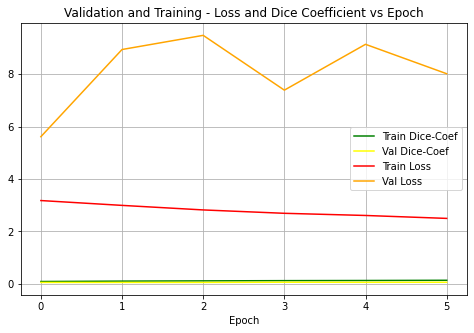

In [ ]:
print("Basic UNET Model\n")
PlotMetrics(history)

In [ ]:
# Pickle dump the history dictionary
filename = basic_unet_i64_b64_e6_history
filehandle = open(filename, "wb")
pickle.dump(history.history, filehandle)
filehandle.close()

In [ ]:
basic_unet_i64_b64_e6_model.load_weights(basic_unet_i64_b64_e6_path)

BASIC UNET MODEL - CONFUSION MATRIX

Total samples =  1068


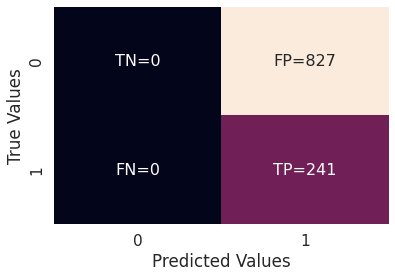

In [ ]:
# Get predictions for Validation dataset and evaluate model performance
y_true,y_pred = get_predictions(basic_unet_i64_b64_e6_model, val_df, train_path, input_size=INPUT_SIZE_64)

print("BASIC UNET MODEL - CONFUSION MATRIX\n")
print_confusion_matrix(y_true, y_pred)

In [ ]:
print("BASIC UNET MODEL : CLASSIFICATION REPORT\n")
print(classification_report(y_true, y_pred))

BASIC UNET MODEL : CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       827
           1       0.23      1.00      0.37       241

    accuracy                           0.23      1068
   macro avg       0.11      0.50      0.18      1068
weighted avg       0.05      0.23      0.08      1068



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Pickle dump the report dictionary
report = classification_report(y_true, y_pred, output_dict=True)
filename = basic_unet_i64_b64_e6_creport
filehandle = open(filename, "wb")
pickle.dump(report, filehandle)
filehandle.close()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# load the best weights and save using model.save to make sure the model can be retrieved later
best_weights = basic_unet_i64_b64_e6_path
basic_unet_i64_b64_e6_model.load_weights(best_weights)
best_model_path  = basic_unet_i64_b64_e6_model_path
basic_unet_i64_b64_e6_model.save(best_model_path)